##### Grading Feedback Cell
105

# IST 718: Big Data Analytics

- Professor: Willard Williamson <wewillia@syr.edu>
- Faculty Assistant: Yash Pasar <yspasar@syr.edu>
## General instructions:

- You are welcome to discuss the problems with your classmates but __you are not allowed to copy any part of your answers from your classmates.  Short code snippets are allowed from the internet.  Code from the class text books or class provided code can be copied in its entirety.__
- There could be tests in some cells (i.e., `assert` and `np.testing.` statements). These tests (if present) are used to grade your answers. **However, the professor and FAs could use __additional__ test for your answer. Think about cases where your code should run even if it passess all the tests you see.**
- Before submitting your work, remember to check for run time errors with the following procedure:
`Kernel`$\rightarrow$`Restart and Run All`.  All runtime errors will result in a minimum penalty of half off.
- Data Bricks is the official class runtime environment so you should test your code on Data Bricks before submission.  If there is a runtime problem in the grading environment, we will try your code on Data Bricks before making a final grading decision.
- All plots shall include a title, and axis labels.
- Grading feedback cells are there for graders to provide feedback to students.  Don't change or remove grading feedback cells.
- Don't add or remove files from your git repo.
- Do not change file names in your repo.  This also means don't change the title of the ipython notebook.
- __Only use spark, spark machine learning, spark data frames, RDD's, and map reduce to solve all problems unless instructed otherwise.__

In [39]:
# read only cell

import os

# get the databricks runtime version
db_env = os.getenv("DATABRICKS_RUNTIME_VERSION")

# Define a function to read the data file.  The full path data file name is constructed
# by checking runtime environment variables to determine if the runtime environment is 
# databricks, or a student's personal computer.  The full path file name is then
# constructed based on the runtime env.
# 
# Params
#   data_file_name: The base name of the data file to load
# 
# Returns the full path file name based on the runtime env
#
def get_training_filename(data_file_name):    
    # if the databricks env var exists
    if db_env != None:
        # build the full path file name assuming data brick env
        full_path_name = "/FileStore/tables/%s" % data_file_name
    # else the data is assumed to be in the same dir as this notebook
    else:
        # Assume the student is running on their own computer and load the data
        # file from the same dir as this notebook
        full_path_name = data_file_name
    
    # return the full path file name to the caller
    return full_path_name

In [40]:
# import statements here
# create spark and sparkcontext objects
from pyspark.sql import SparkSession
from pyspark.sql import Row
import numpy as np
import pandas as pd
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

# Moore's Law
The frequently cited “Moore’s Law” originated with a 1965 article in Electronics magazine that said the number of transistors in a given area would double every year.

### ONLY use spark functions unless the question instructions say otherwise.

## Question 1 Load the Transistor Data (5 pts)
- Read the MooresLaw.txt file into a spark data frame named trans_df using only spark.  The columns should be named as per the header in the txt file.
- Print the first 5 rows of trans_df 
- Print the shape of trans_df (num_rows, num_cols)
- Make sure to use the get_training_filename function above to obtain the file name based on your runtime environment

In [41]:
# your code here
#trans_df = spark.read.csv('mooresLaw.txt', header=True, delimiter ="\t", inferSchema=True)
#display(trans_df.head())

trans_df = spark.read.option("header","true")\
           .option("delimiter","\t")\
           .option("inferSchema","true")\
           .csv('mooresLaw.txt')

print(trans_df.limit(5).show())


+---------------+------+-----------+----+----+----+----+
|Intel Processor|  Year|Transistors| _c3| _c4| _c5| _c6|
+---------------+------+-----------+----+----+----+----+
|           4004|1971.9|       2300|null|null|null|null|
|           8008|1972.3|       3500|null|null|null|null|
|           8080|1974.3|       6000|null|null|null|null|
|           8085|1976.3|       6500|null|null|null|null|
|           8086|1978.5|      29000|null|null|null|null|
+---------------+------+-----------+----+----+----+----+

None


In [42]:
print("Shape: ",(trans_df.count(), len(trans_df.columns)))

Shape:  (74, 7)


##### Grading Feedback Cell

## Question 2 Transistor Data Cleanup (5 pts)
- Drop all columns in trans_df except the Year and Transistors column.
- Drop rows in trans_df that contain NaN vales
- Prove that trans_df does not contain NaN values by showing a single integer sum of the number of Nan values in the dataframe (should equal 0)

In [43]:
# your code here
columns_to_drop = ['Intel Processor', '_c3', '_c4', '_c5', '_c6']

trans_df = trans_df.drop(*columns_to_drop)

In [44]:
trans_df.printSchema()

root
 |-- Year: double (nullable = true)
 |-- Transistors: long (nullable = true)



In [45]:
trans_df = trans_df.na.drop()

In [46]:
from pyspark.sql.functions import col,sum
trans_df.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in trans_df.columns)).show()

+----+-----------+
|Year|Transistors|
+----+-----------+
|   0|          0|
+----+-----------+



##### Grading Feedback Cell

## Question 3 Transistor Data Exploration (10 pts)


### Question 3a (3 pts) 
Explore the data in trans_df by plotting transistors vs. year with a scatter plot.  You may use packages outside of spark to perform the task in question 3a.

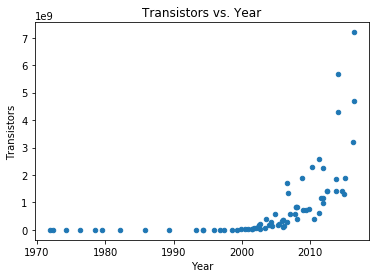

In [47]:
# Your code here
trans_df.select('Year', 'Transistors').toPandas().plot(x='Year', y='Transistors', kind='scatter', title = 'Transistors vs. Year');

##### Grading Feedback Cell

### Question 3b (3 pts)
Compute the correlation between year and number of transistors in the trans_df using spark.  Print the resulting correlation value.  Interpret the correlation in words in the provided markdown cell.

In [48]:
# your code here
from pyspark.sql import functions as fn
trans_df.select(fn.corr('Year', 'Transistors')).show()

+-----------------------+
|corr(Year, Transistors)|
+-----------------------+
|     0.5434352929286356|
+-----------------------+



##### Grading Feedback Cell

### Question 3c (4 pts) 
- Interpret the correlation value computed above in the markdown cell below.

Your correlation interpretation here: The correlation between Year and Transistors is 0.54, which means that there is a positive relationship between Year and Transistors. As the year progresses, the Transistors keep on increasing. This correlation value agrees with Moore's Law which talks about how the number of transistors double every year


##### Grading Feedback Cell

## Question 4 Transform the Data (10 pts)

### Question 4a (5 pts)
- Create a new data frame named trans_df_2 that adds a log transform to the transistors col in trans_df.
- Print the head of trans_df_2
- Print the shape of trans_df_2

In [49]:
# your code here
trans_df_2 = trans_df.select('Year','Transistors',fn.log('Transistors').alias('Log_Transistors'))
trans_df_2.head()

Row(Year=1971.9, Transistors=2300, Log_Transistors=7.7406644019172415)

In [50]:
#trans_df_2 =trans_df_2.selectExpr("cast(Year as int) Year","cast(Transistors as int) Transistors")

In [51]:
trans_df_2.printSchema()
print("Shape:",(trans_df_2.count(), len(trans_df_2.columns)))

root
 |-- Year: double (nullable = true)
 |-- Transistors: long (nullable = true)
 |-- Log_Transistors: double (nullable = true)

Shape: (74, 3)


##### Grading Feedback Cell

### Question 4b (5 pts)
- Using trans_df_2, create a scatter plot of log transistors vs. year.  You may use packages outside of spark for this task.

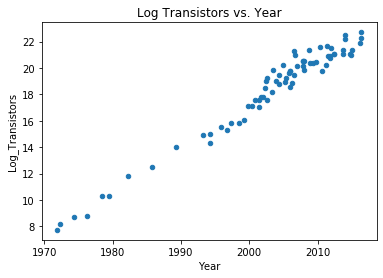

In [52]:
# Your code here
trans_df_2.select('Year','Log_Transistors').toPandas().plot(x='Year', y='Log_Transistors', kind='scatter', title = 'Log Transistors vs. Year');

##### Grading Feedback Cell

## Question 5 Fit a Linear Regression Pipeline (10 pts)

### Question 5a ( 2 pts)
- Split trans_df_2 into train and test splits with a 60:40 ratio.  Name the resulting data frames trans_train and trans_test.  Print the shape of of the train and test data frames.

In [53]:
# your code here
trans_train,trans_test = trans_df_2.randomSplit([0.6, 0.4], )

print("Shape of trans_train:",(trans_train.count(), len(trans_df_2.columns)))

print("Shape of trans_test:",(trans_test.count(), len(trans_df_2.columns)))


Shape of trans_train: (40, 3)
Shape of trans_test: (34, 3)


##### Grading Feedback Cell

### Question 5b (6 pts)
- Create a spark pipeline named trans_pipe to perform linear regression
- Fit the pipeline using the transistors as the targets and year as the features.  Name the resulting fitted pipeline fitted_trans_pipe.
- Fit another pipeline using the log transistors column as the targets and year as the features.  Name the resulting fitted pipeline log_fitted_trans_pipe.

In [54]:
# Functionality for computing features
from pyspark.ml import feature
# Functionality for regression
from pyspark.ml import regression
# Funcionality for classification
from pyspark.ml import classification
# Object for creating sequences of transformations
from pyspark.ml import Pipeline

In [55]:
# your code here
va = feature.VectorAssembler(inputCols=['Year'], outputCol='features')
lr = regression.LinearRegression(featuresCol='features', labelCol='Transistors')
trans_pipe = Pipeline(stages=[va, lr])
fitted_trans_pipe = trans_pipe.fit(trans_train)

# your code here
va1 = feature.VectorAssembler(inputCols=['Year'], outputCol='features')
lr1 = regression.LinearRegression(featuresCol='features', labelCol='Log_Transistors')
trans_pipe1 = Pipeline(stages=[va1, lr1])
log_fitted_trans_pipe = trans_pipe1.fit(trans_train)

In [56]:
print("Target Variable as Transistors:")
fitted_trans_pipe.transform(trans_train).show(5)

print("Target Variable as Log_Transistors:")
log_fitted_trans_pipe.transform(trans_train).show(5)

Target Variable as Transistors:
+------+-----------+------------------+--------+--------------------+
|  Year|Transistors|   Log_Transistors|features|          prediction|
+------+-----------+------------------+--------+--------------------+
|1971.9|       2300|7.7406644019172415|[1971.9]|-1.25694592711570...|
|1974.3|       6000| 8.699514748210191|[1974.3]|-1.090801442446869E9|
|1982.2|     134000|11.805595078933049|[1982.2]|-5.439091804119415E8|
|1985.8|     275000|12.524526376648708|[1985.8]|-2.946924534086914E8|
|1993.3|    3100000|14.946912669455374|[1993.3]|  2.24509061181427E8|
+------+-----------+------------------+--------+--------------------+
only showing top 5 rows

Target Variable as Log_Transistors:
+------+-----------+------------------+--------+------------------+
|  Year|Transistors|   Log_Transistors|features|        prediction|
+------+-----------+------------------+--------+------------------+
|1971.9|       2300|7.7406644019172415|[1971.9]| 8.221641939167512|
|1974

##### Grading Feedback Cell

### Question 5c (2 pts)
- Print the linear regression coefficient in the linear regression object in each fitted model
- Print the linear regression Y intercept in the linear regression object in each fitted model

In [57]:
# your code here
print("linear regression coefficient: ",fitted_trans_pipe.stages[1].coefficients)
print("linear regression coefficient for Log Transistors: ",log_fitted_trans_pipe.stages[1].coefficients)
print("linear regression Y intercept: ",fitted_trans_pipe.stages[1].intercept)
print("linear regression Y intercept for Log Transistors: ",log_fitted_trans_pipe.stages[1].intercept)


linear regression coefficient:  [69226868.61201546]
linear regression coefficient for Log Transistors:  [0.32346243457897017]
linear regression Y intercept:  -137765408143.149
linear regression Y intercept for Log Transistors:  -629.6139328071038


##### Grading Feedback Cell

### Question 6 Test the linear regression pipeline (10 pts)

### Question 6a (5 pts)
- Compute mean squared error (MSE) using the transform method on each fitted model.
- Print the resulting MSEs.

In [58]:
# your code here
mse = fn.mean((fn.col('Transistors') - fn.col('prediction'))**2).alias('mse')
Log_mse = fn.mean((fn.col('Log_Transistors') - fn.col('prediction'))**2).alias('mse')

print("--------------MSE for Test DataSet----------")
print("MSE for Transistors:")
fitted_trans_pipe.transform(trans_test).select(mse).show()
print("MSE for Log_Transistors:")
log_fitted_trans_pipe.transform(trans_test).select(Log_mse).show()


--------------MSE for Test DataSet----------
MSE for Transistors:
+--------------------+
|                 mse|
+--------------------+
|1.158890922259468...|
+--------------------+

MSE for Log_Transistors:
+-------------------+
|                mse|
+-------------------+
|0.43000988430448583|
+-------------------+



##### Grading Feedback Cell

### Question 6b (5 pts)
- Using log_fitted_trans_pipe and any needed support code, predict and print the number of transistors for the years 1970.0, 1980.0, 1990.0, 2000.0, and 2010.0

In [59]:
from math import exp, log10, fabs, atan, log
t_1970 = exp(log_fitted_trans_pipe.stages[1].intercept + (log_fitted_trans_pipe.stages[1].coefficients[0])*1970)
t_1980 = exp(log_fitted_trans_pipe.stages[1].intercept + (log_fitted_trans_pipe.stages[1].coefficients[0])*1980)
t_1990 = exp(log_fitted_trans_pipe.stages[1].intercept + (log_fitted_trans_pipe.stages[1].coefficients[0])*1990)
t_2000 = exp(log_fitted_trans_pipe.stages[1].intercept + (log_fitted_trans_pipe.stages[1].coefficients[0])*2000)
t_2010 = exp(log_fitted_trans_pipe.stages[1].intercept + (log_fitted_trans_pipe.stages[1].coefficients[0])*2010)
print("No. of Transistors in year 1970: ",t_1970)
print("No. of Transistors in year 1980: ",t_1980)
print("No. of Transistors in year 1990: ",t_1990)
print("No. of Transistors in year 2000: ",t_2000)
print("No. of Transistors in year 2010: ",t_2010)



No. of Transistors in year 1970:  2012.3597420395145
No. of Transistors in year 1980:  51107.557383433814
No. of Transistors in year 1990:  1297969.9241318314
No. of Transistors in year 2000:  32964320.938114204
No. of Transistors in year 2010:  837189240.4501895


##### Grading Feedback Cell

# Climate Change

## Question 7 Load the global warming data (5 pts)
- Read the globalWarm.txt file into a spark data frame named global_warm_df using only spark.  The columns should be named as per the header in the txt file.
- Print the first 5 rows of global_warm_df 
- Print the shape of global_warm_df (num_rows, num_cols)
- Make sure to use the get_training_filename function above to obtain the file name based on your runtime environment
- A data description follows:
<ul>
<li/>Temp = annual surface temperature measured in 1/100<sup>o</sup> C   over the 1950-1980 mean.  
<li/>Solar = annual mean intensity of sunlight piercing the atmosphere
<li/>CO2 = annual average fraction CO<sub>2</sub> in atmosphere (#molecules/#molecules of dry air) 
<li/>IceShelf = sea ice in 1MM square miles  hypothesized to reflect heat
<li/>Transmission = volcanic MLO transmission data where eruptions release greenhouse gases but also decrease the temperature
</ul>

In [60]:
# your code here
global_warm_df = spark.read.option("header","true")\
           .option("delimiter","\t")\
           .option("inferSchema","true")\
           .csv('globalWarm.txt')

print(global_warm_df.limit(5).show())


+----+----+------+-------+------------+--------+
|Year|Temp|   CO2|  Solar|Transmission|IceShelf|
+----+----+------+-------+------------+--------+
|1979|   8|336.67|1366.43| 0.928466667|     7.2|
|1980|  19|338.57|1366.51| 0.929666667|    7.85|
|1981|  26|339.92|1366.51| 0.929766667|    7.25|
|1982|   4| 341.3|1366.16| 0.853066667|    7.45|
|1983|  25|342.71|1366.18| 0.897716667|    7.52|
+----+----+------+-------+------------+--------+

None


In [61]:
print("Shape: ",(global_warm_df.count(), len(global_warm_df.columns)))

Shape:  (32, 6)


##### Grading Feedback Cell

## Question 8 Global Warming Data Exploration (5 pts)
- Create a temperature vs. year scatter plot from global_warm_df
- You may use packages outside of spark for this question

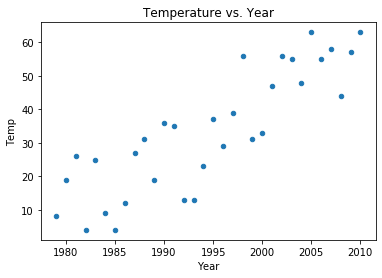

In [62]:
# your code here
# Your code here
global_warm_df.select('Year', 'Temp').toPandas().plot(x='Year', y='Temp', kind='scatter', title = 'Temperature vs. Year');

##### Grading Feedback Cell

## Question 9 Global Warming Data Exploration (10 pts)


### Question 9a (5 pts)
- Using global_warm_df, create a pair plot of the following variables in a grid:  Temp, CO<sub>2</sub>, Solar, Transmission, and IceShelf.
- You may use packages outside of spark for this question

Text(0.5, 1.01, 'Pair Plot of Temp, CO2, Solar, Transmission, IceShelf')

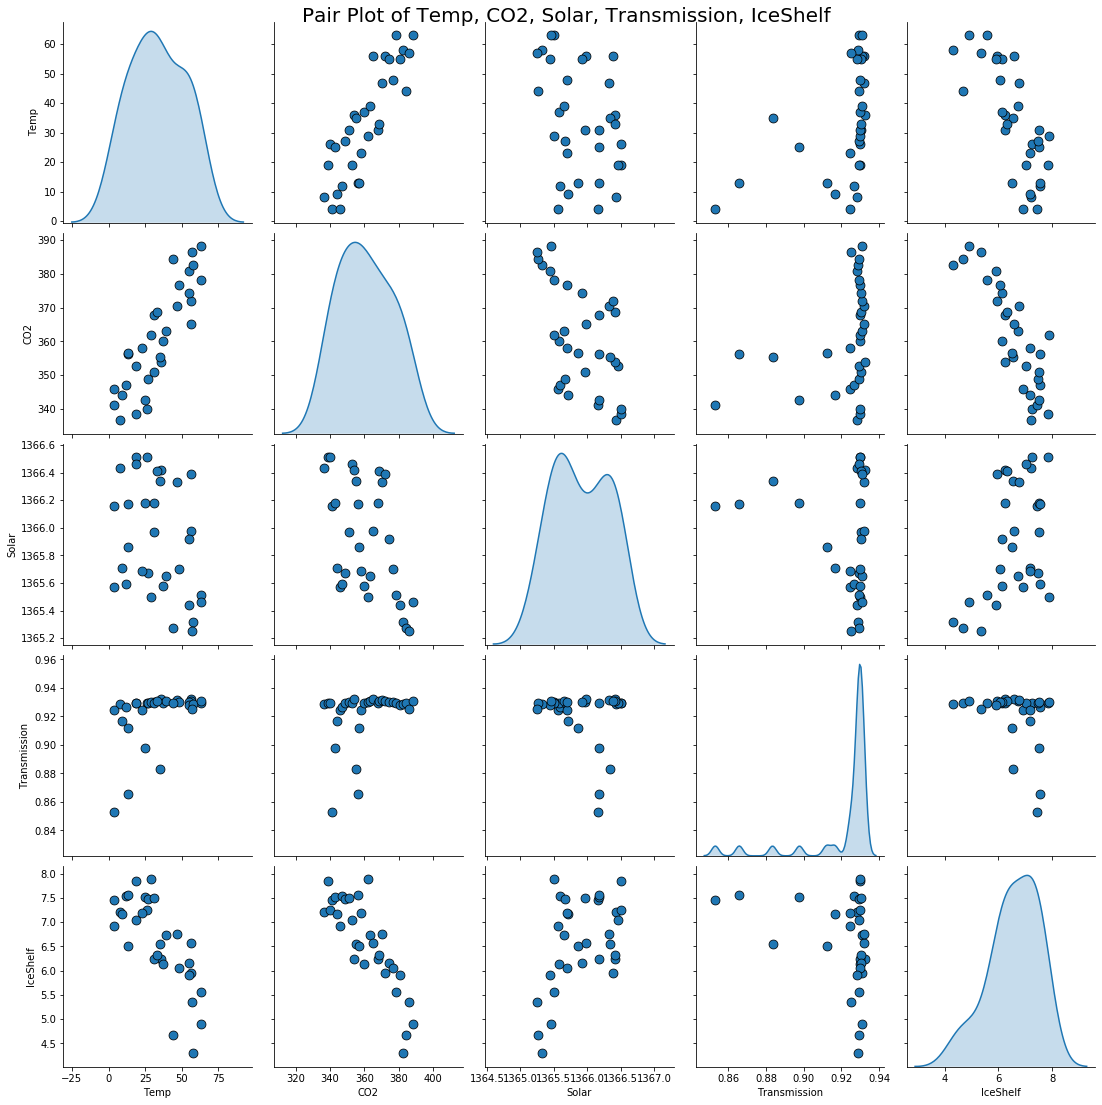

In [63]:
# your code here
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.pairplot(global_warm_df.toPandas(), 
             vars = ['Temp', 'CO2', 'Solar','Transmission','IceShelf'], 
             diag_kind = 'kde', 
             plot_kws = {'alpha': 1.0, 's': 80, 'edgecolor': 'k'},
             height = 3);

ax.fig.suptitle('Pair Plot of Temp, CO2, Solar, Transmission, IceShelf', y=1.01,size=20)


##### Grading Feedback Cell

### Question 9b (5 pts)
- Compute a correlation matrix between Temp, CO<sub>2</sub>, Solar, Transmission, and IceShelf using spark.
- Print a labeled correlation matrix.

In [64]:
from pyspark.mllib.stat import Statistics
columns_to_drop_1 = ['Year']
global_warm_df_1 = global_warm_df.drop(*columns_to_drop_1)

col_names = global_warm_df_1.columns
features = global_warm_df_1.rdd.map(lambda row: row[0:])
corr_mat=Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names
print("*******CORRELATION MATRIX************")
print(corr_df.to_string())

*******CORRELATION MATRIX************
                  Temp       CO2     Solar  Transmission  IceShelf
Temp          1.000000  0.860927 -0.340342      0.435394 -0.747425
CO2           0.860927  1.000000 -0.542822      0.328228 -0.846961
Solar        -0.340342 -0.542822  1.000000     -0.205848  0.470690
Transmission  0.435394  0.328228 -0.205848      1.000000 -0.302484
IceShelf     -0.747425 -0.846961  0.470690     -0.302484  1.000000


##### Grading Feedback Cell

## Question 10 Fit Linear Regression Pipelines (10 pts)

### Question 10a (2 pts)
Split global_warm_df into train and test splits with a 60:40 ratio.  Name the resulting data frames gw_train and gw_test.  Print the shape of of the train and test data frames.   

In [65]:
# your code here
gw_train,gw_test = global_warm_df.randomSplit([0.6, 0.4], )

print("Shape of trans_train:",(gw_train.count(), len(global_warm_df.columns)))

print("Shape of trans_test:",(gw_test.count(), len(global_warm_df.columns)))

Shape of trans_train: (20, 6)
Shape of trans_test: (12, 6)


##### Grading Feedback Cell

### Question 10b (6 pts)
- Create a spark pipeline named global_warm_pipe to perform linear regression.
- Use the global_warm_df data frame
- Fit a pipeline on the temp column as the target and CO2 as the feature.  Name the resulting fitted pipeline fitted_global_warm_pipe.
- Fit another pipeline on the temp column as the target and all other columns except year as the features.  Name the resulting fitted pipeline fitted_global_warm_pipe_2.

In [66]:
# your code here
va = feature.VectorAssembler(inputCols=['CO2'], outputCol='features')
lr = regression.LinearRegression(featuresCol='features', labelCol='Temp')
global_warm_pipe = Pipeline(stages=[va, lr])
fitted_global_warm_pipe = global_warm_pipe.fit(gw_train)

va1 = feature.VectorAssembler(inputCols=['CO2','Solar','Transmission','IceShelf'], outputCol='features')
lr1 = regression.LinearRegression(featuresCol='features', labelCol='Temp')
global_warm_pipe1 = Pipeline(stages=[va1, lr1])
fitted_global_warm_pipe_2 = global_warm_pipe1.fit(gw_train)

##### Grading Feedback Cell

### Question 10c (2 pts)
- Print the linear regression coefficient(s) in the linear regression object in each fitted model
- Print the linear regression Y intercept in the linear regression object in each fitted model

In [67]:
# your code here
print("linear regression coefficient: ",fitted_global_warm_pipe.stages[1].coefficients)
print("linear regression coefficient for CO2, Solar, Transmission, IceShelf: ",fitted_global_warm_pipe_2.stages[1].coefficients)
print("linear regression Y intercept: ",fitted_global_warm_pipe.stages[1].intercept)
print("linear regression Y intercept for CO2, Solar, Transmission, IceShelf: ",fitted_global_warm_pipe_2.stages[1].intercept)

linear regression coefficient:  [1.0393381283614407]
linear regression coefficient for CO2, Solar, Transmission, IceShelf:  [0.9062498471714141,7.892500992285567,139.91890409926916,-3.0537097894219625]
linear regression Y intercept:  -343.9318699926861
linear regression Y intercept for CO2, Solar, Transmission, IceShelf:  -11184.738114275224


##### Grading Feedback Cell

### Question 11 Test the linear regression pipeline (10 pts)

### Question 11a (5 pts)
- Compute mean squared error (MSE) using the transform method on each fitted model.
- Print the resulting MSEs.

In [68]:
# your code here
gw_mse = fn.mean((fn.col('Temp') - fn.col('prediction'))**2).alias('mse')

print("--------------MSE for Test DataSet----------")
print("MSE for Temp with CO2:")
fitted_global_warm_pipe.transform(gw_test).select(gw_mse).show()
print("MSE for Temp with all other variables except Year:")
fitted_global_warm_pipe_2.transform(gw_test).select(gw_mse).show()

--------------MSE for Test DataSet----------
MSE for Temp with CO2:
+------------------+
|               mse|
+------------------+
|102.16471108553328|
+------------------+

MSE for Temp with all other variables except Year:
+-----------------+
|              mse|
+-----------------+
|85.10526745335501|
+-----------------+



##### Grading Feedback Cell

### Question 11b (5 pts)
- Which of the 2 models have higher performance.  In the cell below, describe why you think the better performing model made the model perform better.

The model with all the features is performing better because by increasing the number of features, the variance of the model is increasing and thereby the fit of the model is improving which is reducing the bias and since the predicted values are closer to the actual values, the MSE is also lower for the model with all the features, which is the better performing model.

### Question 12 Inference (10 pts)

### Question 12a Data Scaling (5 pts)
Add data scaling to fitted_global_warm_pipe_2 above. Name the resulting fitted model fitted_global_warm_pipe_3.  Print the resulting fitted model coefficients such that each coefficient is clearly labeled with it's corresponding feature name.

In [69]:
va2 = feature.VectorAssembler(inputCols=['CO2','Solar','Transmission','IceShelf'], outputCol='features')
sc = feature.StandardScaler(withMean=True,withStd= True,inputCol='features',outputCol="sc_features")
lr2 = regression.LinearRegression(featuresCol='sc_features',labelCol='Temp')
scaled_pipe = Pipeline(stages=[va2, sc, lr2])
fitted_global_warm_pipe_3 = scaled_pipe.fit(gw_train)
print("Intercept of the model: ",fitted_global_warm_pipe_3.stages[2].intercept)
print("Coefficient of CO2: ",fitted_global_warm_pipe_3.stages[2].coefficients[0])
print("Coefficient of Solar: ",fitted_global_warm_pipe_3.stages[2].coefficients[1])
print("Coefficient of Transmission: ",fitted_global_warm_pipe_3.stages[2].coefficients[2])
print("Coefficient of IceShelf: ",fitted_global_warm_pipe_3.stages[2].coefficients[3])


Intercept of the model:  31.699999999998596
Coefficient of CO2:  15.266045430881134
Coefficient of Solar:  3.448568532062011
Coefficient of Transmission:  3.087421291455947
Coefficient of IceShelf:  -3.302906428654538


### Question 12b Inference (5 pts)  
Use the coefficients printed above to gain insights into the global warming problem. Describe your inference conclusions in the cell below.

Coefficient inference conclusions here: The insights that we can obtain from these coefficients are that, CO2, Transmission and solar have a positive impact on temperature, i.e. an increase in CO2 or Transmission or Solar will result in an increase in temperature, whereas on the other hand IceShelf has a negative impact on temperature, i.e. an increase in IceShelf will result in a decrease in temperature. The coefficient of CO2 is 21.35 which indicates that, 1 standard deviation increase in CO2, keeping all the other variables constant will result in 21.35 units increase in temperature. When IceShelf increases by 1 standard deviation the temperature is going to decrease by 0.15 units.When all the variables are 0, the temperature is going to be equal to the intercept.

##### Grading Feedback Cell

# Question 13 Extra Credit (10 pts)
This question is optional.  No points will be deducted from your score if you do not attempt this problem.<br>

Starting with the rdd class presented in lecture (maintaining all class method names), implement a my_reduce method in the rdd class.  Your implementation shall maintain rdd class immutability.  Your my_reduce method return type should be consistent with the return type in the real Spark reduce method. Do some research and see what the Spark reduce return type would be.  <br>

Implement a function named times_3 which returns its input multiplied by 3. Implement a function named is_even that returns true if it's input is even, false otherwise.  Implement a my_sum function that returns the sum of its 2 inputs.  <br>

Your overall implementation should not rely on receiving specific data types as inputs.  For example, the plus operator works on more than just ints and floats.

In [70]:
# your code here
def times_3(a):
    return a*3
def is_even(a):
    if a%2 == 0:
        return True
    else:
        return False
def my_sum(a,b):
    return a + b

# defining class
class rdd:
    def __init__(self,c):
        self.array_1 = c
        
    # map function
    def my_map(self,c):
        if len(self.array_1) < 1:
            raise Exception("my_map: len(array_1) < 1")
        
        # for storing result as rdd need to be immutable
        result_array = np.empty_like(self.array_1,dtype = np.double)
        
        # applying user defined functions
        for i, j in enumerate(self.array_1):
            result_array[i]=c(float(self.array_1[i]))
            
        return rdd(result_array)
    
    def my_filter(self,c):
        filtered = []
        for j in self.array_1:
            filtered.append(j)
            
        return rdd(np.array(filtered))
    
    
    def my_reduce(self,c):
        if len(self.array_1) < 1:
            raise Exception("my_map: len(array_1)<1")
            
        result_array = np.empty_like(self.array_1, dtype = np.double)
        
        for i, j in enumerate(self.array_1):
            result_array[i]=c((0 if (i==0) else result_array[i-1]),float(self.array_1[i]))
        
        return rdd(result_array[-1])
    
    def my_collect(self):
        return self.array_1
    


In [76]:
# Simple test code
test_rdd = rdd(np.arange(100))
result = test_rdd.my_map(times_3).my_filter(is_even).my_reduce(my_sum)
print(type(result))
print(result)
# secret grading test code follows


<class '__main__.rdd'>


##### Grading Feedback Cell
-5 for not returning an integer